In [1]:
%matplotlib inline
from __future__ import print_function

In [67]:
import keras
from keras.models import model_from_json

#load the keras models
#weights_file = "Feb242017_allTasks/tim_equivalent_sequential/model_files/record_1_model_Qc59d_modelWeights.h5"
#json_file = "Feb242017_allTasks/tim_equivalent_sequential/model_files/record_1_model_Qc59d_modelJson.json"

weights_file = "Feb25_newdata/tim_equivalent/model_files/record_1_model_gLwf2_modelWeights.h5"
json_file = "Feb25_newdata/tim_equivalent/model_files/record_1_model_gLwf2_modelJson.json"

keras_model = model_from_json(open(json_file).read())
keras_model.load_weights(weights_file)

In [68]:
keras_model.layers

In [69]:
import deeplift
from collections import OrderedDict
from deeplift.conversion import keras_conversion as kc
reload(kc)
from deeplift.blobs.core import NonlinearMxtsMode, DenseMxtsMode

#assumes branch: splitting_pos_and_neg for DeepLIFT

method_to_model = OrderedDict()
method_to_model['grad_times_inp'] = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.Gradient)
method_to_model['rescale'] = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)
method_to_model['revealcancel_shushconvs'] = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel,
                                                              layer_overrides={2: {'nonlinear_mxts_mode':NonlinearMxtsMode.Rescale},
                                                                               6: {'nonlinear_mxts_mode':NonlinearMxtsMode.Rescale},
                                                                               10: {'nonlinear_mxts_mode':NonlinearMxtsMode.Rescale}})
method_to_model['revealcancel_shushconvsandfirstfc'] = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel,
                                                              layer_overrides={2: {'nonlinear_mxts_mode':NonlinearMxtsMode.Rescale},
                                                                               6: {'nonlinear_mxts_mode':NonlinearMxtsMode.Rescale},
                                                                               10: {'nonlinear_mxts_mode':NonlinearMxtsMode.Rescale},
                                                                               14: {'nonlinear_mxts_mode':NonlinearMxtsMode.Rescale}})

Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear
Heads-up: Maxpool implementation assumes your Conv/Dense mxts modes are Linear


In [70]:
#sanity check that I overrode the right layer
print(method_to_model['revealcancel_shushconvsandfirstfc'].get_layers()[15].name)
method_to_model['revealcancel_shushconvsandfirstfc'].get_layers()[15].nonlinear_mxts_mode 

14


'Rescale'

In [71]:
#compile different kinds of scoring functions
method_to_func = OrderedDict()
for method in method_to_model:
    method_to_func[method] = method_to_model[method].get_target_contribs_func(target_layer_idx=-2,
                                                                              find_scores_layer_idx=0)

INFO (theano.gof.compilelock): Refreshing lock /users/avanti/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.11-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /users/avanti/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.11-64/lock_dir/lock


Predictions
1/1 [==============================] - 0s
[0.069211468100547791, 0.029796643182635307, 0.34293720126152039]
('chr5', 154032700, 154034700)
task 0
Method grad_times_inp


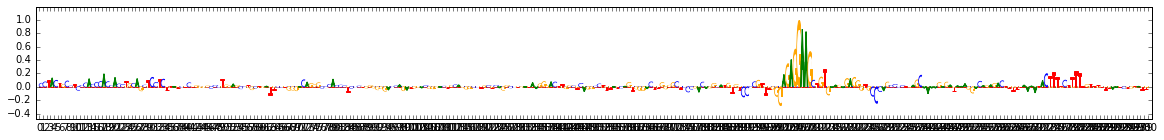

Method rescale


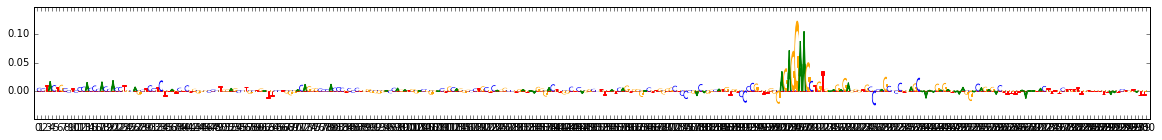

Method revealcancel_shushconvs


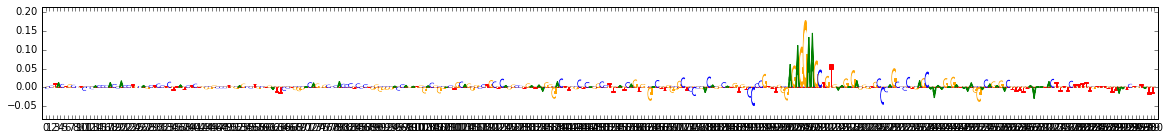

task 5
Method grad_times_inp


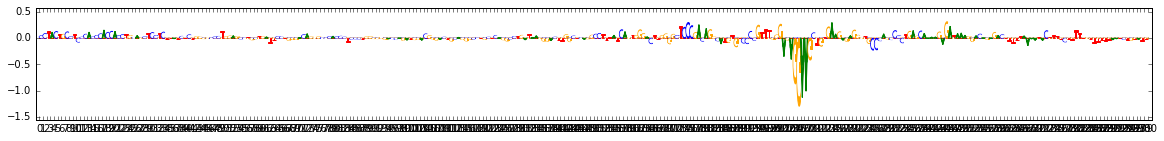

Method rescale


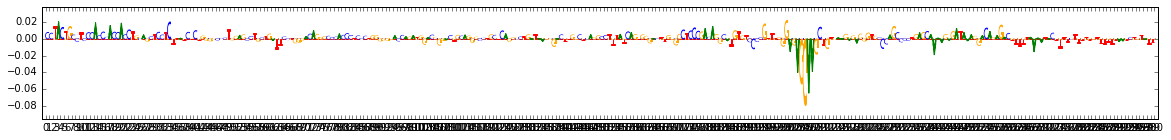

Method revealcancel_shushconvs


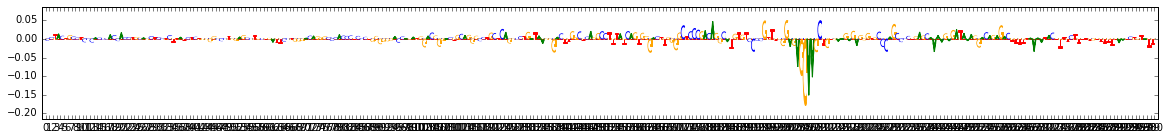

task 7
Method grad_times_inp


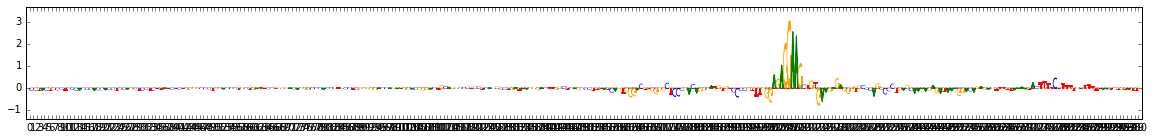

Method rescale


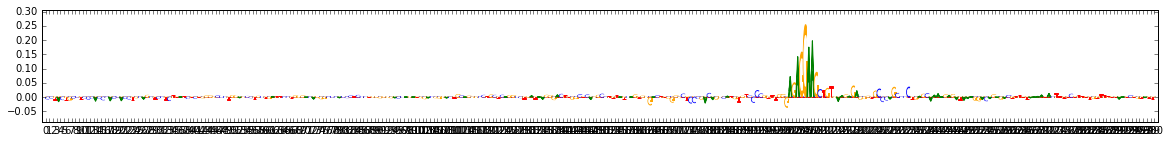

Method revealcancel_shushconvs


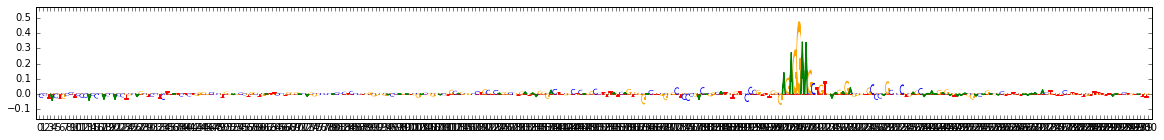

In [72]:
from avutils.util import seq_to_2d_image
from deeplift.visualization.viz_sequence import plot_weights
import deeplift
import numpy as np
reload(deeplift.util)
reload(deeplift)
import avutils
from avutils.dinuc_shuffle import dinuc_shuffle

regions_to_viz = [
#    ("chr5",154033200,154034200)
    ("chr5",154032700,154034700)
    #("chr5",154033225,154034225)
    #("chr5",154032675,154034675) 2kb
]
!touch temp.bed
fh = open('temp.bed','w')
for chrom,start,end in regions_to_viz:
    fh.write(chrom+"\t"+str(start)+"\t"+str(end)+"\n")
fh.close()

#getfasta
!bedtools getfasta -fi /mnt/data/annotations/by_organism/human/hg19.GRCh37/hg19.genome.fa -tab -bed temp.bed -fo temp.fa
input_data_sequences = [x.split("\t")[1] for x in open('temp.fa','r').read().split("\n") if len(x) > 0]
onehot_inp = np.array([seq_to_2d_image(x) for x in input_data_sequences])

tasks = [0, 5, 7]
#compute the scores on regions_to_viz
task_to_method_to_scores = OrderedDict()

for task in tasks:
    task_to_method_to_scores[task] = OrderedDict()
    for method in method_to_func:
        scoring_func = method_to_func[method]
        many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
            score_computation_function=scoring_func,
            shuffle_func=avutils.dinuc_shuffle.dinuc_shuffle,
            #func to one-hot encode array of sequences:
            one_hot_func=lambda x: np.array([seq_to_2d_image(seq) for seq in x])
        )
        task_to_method_to_scores[task][method] =\
            np.sum(many_refs_func(
                task_idx=task,
                input_data_sequences = input_data_sequences,
                num_refs_per_seq=50,
                progress_update = None,
                batch_size=200), axis=-2)[:,:,None,:]*onehot_inp #sum scores over channel and project onto base that's present

half_window_to_plot=150 #will plot central half_window_to_plot*2 bp
midpoint = int(onehot_inp.shape[-1]/2)
for i in range(len(regions_to_viz)):
    print("Predictions")
    preds = keras_model.predict_proba(np.array([onehot_inp[i]]))
    print([preds[0,x] for x in tasks])
    print(regions_to_viz[i])
    for task in task_to_method_to_scores:
        print("task",task)
        for method in ['grad_times_inp', 'rescale', 'revealcancel_shushconvs']:
            print("Method",method)
            scores_to_plot = task_to_method_to_scores[task][method][i][:,:,midpoint-half_window_to_plot:midpoint+half_window_to_plot]
            plot_weights(scores_to_plot)